# <font color='b8f797'>Libraries</font> 

In [122]:
import pandas as pd
from math import *
from scipy.optimize import least_squares,minimize
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Importing data

## Tensile test

In [2]:
data_tensile = pd.read_excel('Tensile_data.xlsx')[['Time','Mean strain','Mean stress']][0:20]
time = data_tensile['Time'].to_numpy()
epsilon_exp = data_tensile['Mean strain'].to_numpy()
sigma_exp = data_tensile['Mean stress'].to_numpy()

In [3]:
strain_rate = epsilon_exp.mean() / time[-1]

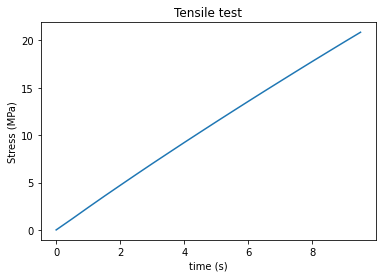

In [4]:
plt.plot(time,sigma_exp)
plt.title("Tensile test")
plt.xlabel("time (s)")
plt.ylabel("Stress (MPa)")
plt.show()


## DMA test

In [5]:
data_DMA = pd.read_excel('Data_DMA_final.xlsx')
freq = data_DMA['frequency'].to_numpy()
stockage = data_DMA["E_stockage"].to_numpy()
loss = data_DMA['E_loss'].to_numpy()

In [6]:
w = freq*2*pi

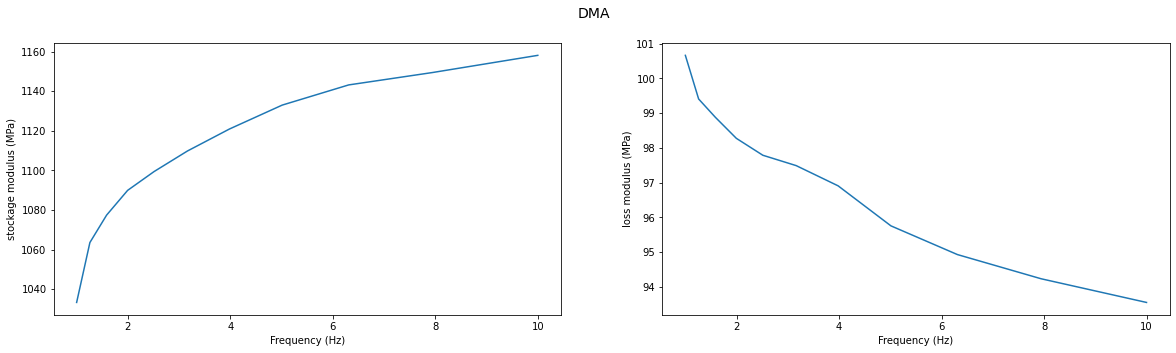

In [7]:
plt.figure(figsize=(20,5))
plt.suptitle("DMA", fontsize=14)
plt.subplot(1,2,1)
plt.plot(freq,stockage)
plt.xlabel("Frequency (Hz)")
plt.ylabel("stockage modulus (MPa)")
plt.subplot(1,2,2)
plt.plot(freq,loss)
plt.xlabel("Frequency (Hz)")
plt.ylabel("loss modulus (MPa)")
plt.show()

# Numerical models

## Loss and stockage moduli

In [115]:
def Moduli(prony_parameters,omega):
    N = prony_parameters.shape[0]//2
    E_infinity = prony_parameters[0]
    E_i = prony_parameters[1:N+1]
    tau_i = prony_parameters[N+1:]
    
    E_stock = E_infinity + sum(E_i[i]*(omega*tau_i[i])**2/(1+(omega*tau_i[i])**2) for i in range(0,N))
    E_loss = sum(E_i[i] * (omega * tau_i[i])/ (1 + (omega * tau_i[i]) ** 2) for i in range(0,N))
    
    return E_stock,E_loss
    
# def E_stockage(E_inf,E,tau,omega):
#     E_sum = sum(E[i]*(omega*tau[i])**2/(1+(omega*tau[i])**2) for i in range(0,E.shape[0]))
#     E_stock = E_inf + E_sum
#     return E_stock

# def E_loss(E,tau,omega):
#     E_loss = sum(E[i] * (omega * tau[i])/ (1 + (omega * tau[i]) ** 2) for i in range(0,E.shape[0]))
#     return E_loss

## Stress

In [160]:
def predicted_stress(time,prony_parameters,strain_rate):
    
    N = prony_parameters.shape[0]//2
    E_infinity = prony_parameters[0]
    E_i = prony_parameters[1:N+1]
    tau_i = prony_parameters[N+1:]

    sigma = np.zeros(time.shape[0])
    sigma_i = np.zeros(N)
    
    for i in range(1,time.shape[0]):
        
        t = time[i]
        t_k = time[i-1]
        
        for j in range(N):
             sigma_i[j] = - ( (sigma_i[j]-E_i[j]*strain_rate*tau_i[j]) * (1 - np.exp((t_k-t)/tau_i[j] ) ) )
            #sigma_i[j] = sigma_i[j] + (E_i[j]*strain_rate*tau_i[j]) * (1 - np.exp((t_k-t)/tau_i[j] ) ) 
            
        sigma[i] = sigma[i-1] + E_infinity*strain_rate*(t - t_k) + sum(sigma_i[j] for j in range(N))
        
    return sigma

# Function to minimize

In [246]:
def function_to_minimize_stress(prony_parameters,data_tensile):
    time = data_tensile['Time'].to_numpy()
    stress_exp = data_tensile['Mean stress'].to_numpy()
    epsilon_exp = data_tensile['Mean strain'].to_numpy()
    strain_rate = epsilon_exp.mean() / time[-1]
    stress_pred = predicted_stress(time,prony_parameters,strain_rate)
    data_tensile

    output = np.sum(( stress_pred / stress_exp -1 ) **2 , axis = 0)
    output_2 = np.sum(abs( stress_pred - stress_exp ), axis = 0)
    return output

In [247]:
def function_to_minimize_moduli(prony_parameters, data_DMA):
    

    frequency = data_DMA['frequency'].to_numpy()
    w = freq*2*pi
    stockage_exp = data_DMA["E_stockage"].to_numpy()
    loss_exp = data_DMA['E_loss'].to_numpy()
    
    Nfrequency = frequency.shape[0]
    
    E_st,E_lo = Moduli(prony_parameters,w)


    output = np.sum((E_st/stockage_exp - 1)**2 + (E_lo/loss_exp -1)**2, axis = 0)
    output_2 = np.sum(abs(E_st-stockage_exp) + abs(E_lo - loss_exp), axis = 0)
    return output


In [248]:
def function_to_minimize_global(prony_parameters,data_tensile,data_DMA):
    output_stress = function_to_minimize_stress(prony_parameters,data_tensile)
    output_moduli = function_to_minimize_moduli(prony_parameters, data_DMA)
    return output_stress + output_moduli

# Optimization

## Prony parameters initialization 

In [104]:
N = 7

E_infinite = np.array([1000]) #valeur initiele E infini
Bound_infinite = np.ones((1,2))

# Young = np.ones(N)
Young = np.random.uniform(1, 200, size = 7)
Bound_Young = np.ones((N,2))

Tau = np.ones(N)
Bound_Tau = np.ones((N,2))

Bound_infinite[0,0] = 1 #borne inferieure E infini
Bound_infinite[0,1] = 2000 #borne supérieure E infini

Bound_Young[:,0] = 1
Bound_Young[:,1] = 300

t_total = np.linspace(0,60,60)

for i in range(0,N):

        if N%2 !=0:
            Tau[i]= 10**(-int(N/2))*10**(i)
        elif N%2 ==0 and i<N/2:
            Tau[i] = 10**(-int(N/2))*10**(i)
            Tau[N-i] = 10**(int(N/2))*10**(-i)
            
Bound_Tau[:,0] = 0.0001
Bound_Tau[:,1] = 1000
Bound   = np.concatenate((Bound_infinite,Bound_Young,Bound_Tau))
prony_parameters = np.concatenate((E_infinite,Young,Tau))
# prony_parameters = np.ones(15)*2
df = pd.DataFrame({'Prony parameters' : prony_parameters[:], 'Inferior boundary' : Bound[:,0], 'Superior boundary' : Bound[:,1]})
df = df.set_index([pd.Index(['E infinity'] + [f'E {i}' for i in range(1,N+1)] + [ f'tau {i}' for i in range(1,N+1)])])
df

,Prony parameters,Inferior boundary,Superior boundary
E infinity,1000.000000,1.0000,2000.0
E 1,122.281179,1.0000,300.0
E 2,86.338879,1.0000,300.0
E 3,98.222094,1.0000,300.0
E 4,71.249289,1.0000,300.0
E 5,95.278733,1.0000,300.0
E 6,9.569270,1.0000,300.0
E 7,67.819081,1.0000,300.0
tau 1,0.001000,0.0001,1000.0
tau 2,0.010000,0.0001,1000.0


## Results

In [110]:
res = minimize(function_to_minimize_global,x0=prony_parameters,args=(data_tensile,data_DMA,),bounds = Bound) #,bounds = Bound
new_prony_parameters = res.x
freq_2 = np.linspace(1,freq[-1],200)
w_2 = freq_2 * 2 * pi
New_E_stoc,New_E_loss = Moduli(new_prony_parameters,w_2)
pd.DataFrame(new_prony_parameters)

,0
0,995.069838
1,113.244687
2,88.908723
3,113.933997
4,46.990693
5,85.921196
6,4.163647
7,62.841803
8,0.031827
9,0.006417


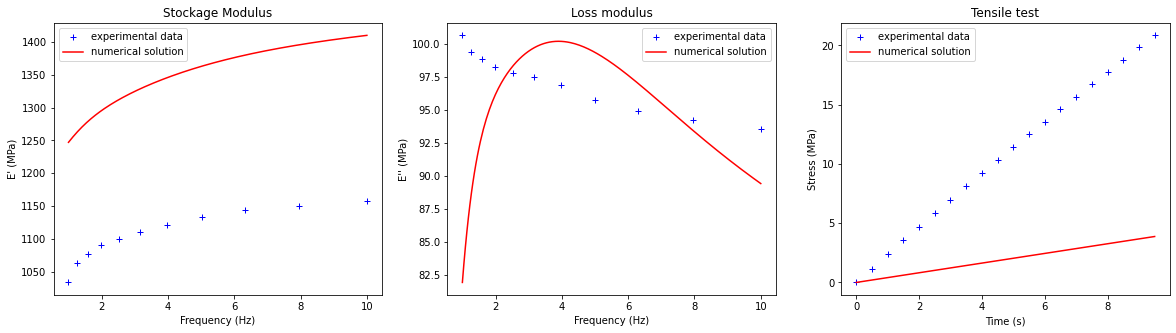

In [112]:
a = plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(freq,stockage,"+b",label='experimental data')
plt.plot(freq_2,New_E_stoc,"r",label='numerical solution')
plt.title("Stockage Modulus")
plt.xlabel("Frequency (Hz)")
plt.ylabel("E' (MPa)")
plt.legend()
plt.subplot(1,3,2)
plt.plot(freq,loss,"+b",label='experimental data')
plt.plot(freq_2,New_E_loss,"r",label='numerical solution')
plt.title("Loss modulus")
plt.xlabel("Frequency (Hz)")
plt.ylabel("E'' (MPa)")
plt.legend()
plt.subplot(1,3,3)
plt.plot(time,sigma_exp,"+b",label='experimental data')
plt.plot(np.linspace(0,time[-1],200) ,predicted_stress(np.linspace(0,time[-1],200) ,new_prony_parameters,strain_rate),"r",label='numerical solution')
plt.title("Tensile test")
plt.xlabel("Time (s)")
plt.ylabel("Stress (MPa)")
a = plt.legend()

# <font color='7ac0f5'>Genetic algorithm</font> 

## Subroutines

In [295]:
def generspon(npara, npop):
    random_gen = np.random.random((npara, npop ))
    return random_gen

def stat(valadapt, pop):
    som = np.sum(valadapt)
    vmoy = np.mean(valadapt)
    vmin = np.min(valadapt)
    vmax = np.max(valadapt)
    
    best = pop[ : , np.argmax(valadapt) ]
    
    ectyp = np.std(valadapt)
    
    return som, vmoy, vmin, vmax, best, ectyp


def tournoi(valadapt, npop, nselect):
    for i in range(npop):
        # randomly select two individuals
        ind1 = np.random.randint(npop)
        ind2 = np.random.randint(npop)
        # select the better individual to be included in the next generation
        if valadapt[ind1] > valadapt[ind2]:
            nselect[i] = ind1
        else:
            nselect[i] = ind2



def reproduction(npara, npop, nselect, pop, newpop, pcross, pmut):
    # copy the selected individuals to the next generation
    newpop[:, :] = pop[:, nselect]
    # randomly select pairs of individuals to be crossed over
    for i in range(0, npop, 2):
        if np.random.random() < pcross:
            
            # calculate the mean of the two parents
            newpop[:, i] = 0.5 * (newpop[:, i] + newpop[:, i+1])
            newpop[:, i+1] = newpop[:, i]

            points = np.random.randint( (2,1) , 7)
            point_1 = np.min(points)
            point_2 = np.max(points)
            
            # newpop[:point, i], newpop[ :point, i+1] = pop[ :point, nselect[i],], pop[:point,nselect[i+1]]
            # newpop[point:,i], newpop[ point:, i+1] = pop[ point:,nselect[i+1]], pop[ point:,nselect[i]]

            # newpop[:,i], newpop[:,i+1] = np.concatenate((newpop[:point_1,i],(newpop[point_1:point_2,i+1]),(newpop[point_2:,i]))), np.concatenate((newpop[:point_1,i+1],(newpop[point_1:point_2,i]),(newpop[point_2:,i+1])))
            
            # mutate each gene with probability pmut
            for j in range(npara):
                if np.random.random() < pmut:
                    newpop[j, i] = np.random.random()
                    newpop[j, i+1] = np.random.random()



def evaluation(pop,data_dma,data_tensile):
    prony_parameters = np.zeros(pop.shape)
    
    prony_parameters[ 0 , : ] = pop[ 0 , : ]*2000+ 1
    prony_parameters[ 1:N+1, : ] = pop [ 1:N+1, : ]*1000 + 1 
    prony_parameters[ N+1: , : ] = pop[ N+1: , : ] * 1000 + 0.001
    
    output = np.zeros(prony_parameters.shape[1])
    for i in range(prony_parameters.shape[1]):
        output_stress = function_to_minimize_stress(prony_parameters[:,i], data_tensile)
        output_moduli = function_to_minimize_moduli(prony_parameters[:,i], data_dma)
        output[i] = ( output_moduli + output_stress + 1 ) ** -1
    return output

In [279]:
def prony_parameters_generation(population):
    prony_parameters = np.zeros(population.shape)
    prony_parameters[ 0 , : ] = population[ 0 , : ]*2000+ 1
    prony_parameters[ 1:N+1, : ] = population [ 1:N+1, : ]*1000 + 1 
    prony_parameters[ N+1: , : ] = population[ N+1: , : ] * 1000 + 0.001
    return prony_parameters

## Model

In [272]:
def genetic_algorithm(npara,npop,maxgen,pmut,pcross, data_dma, data_tensile ):
    pop = generspon(npara,npop )
    valadapt = np.zeros(npop)
    minimum = list()
    maximum = list()
    moyenne = list()
    pmut_init = pmut
    N = npara//2


    for ngen in tqdm(range(1, maxgen+1)):

        
        evaluate = evaluation(pop,data_dma,data_tensile)
        # minindex=evaluate.argmax()
        
        som, vmoy, vmin, vmax, best, ectyp = stat(evaluate, pop)
        if ngen%10 == 0 :
            
            moyenne.append(vmoy)
            maximum.append(vmax)
            minimum.append(vmin)
        
        # Selection and reproduction
        nselect = np.zeros(npop, dtype=int)
        tournoi(evaluate, npop, nselect)
        newpop = np.zeros((npara, npop))
        reproduction(npara, npop, nselect, pop, newpop, pcross, pmut)
        
        pop = newpop
        pop[:,0] = best
        
        pmut = pmut_init #- (np.log(ngen)*0.1)/np.log(maxgen) #reduction of the mutation probability

    return moyenne, maximum, minimum, best

In [296]:
N = 7
npop = 100
maxgen = 1000
npara = 2 * 7 + 1
pcross = 0.8
pmut = 0.8
moyenne, maximum, minimum, best = genetic_algorithm(npara,npop,maxgen,pmut,pcross, data_DMA, data_tensile )

100%|███████████████████████████████████████| 1000/1000 [00:47<00:00, 21.28it/s]


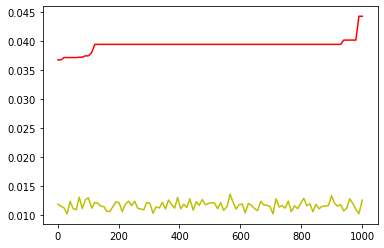

In [297]:
plt.figure()
x = np.linspace(1,maxgen,100,dtype = 'int')

plt.plot(x,maximum,'r')
plt.plot(x,moyenne,'y')
plt.show()

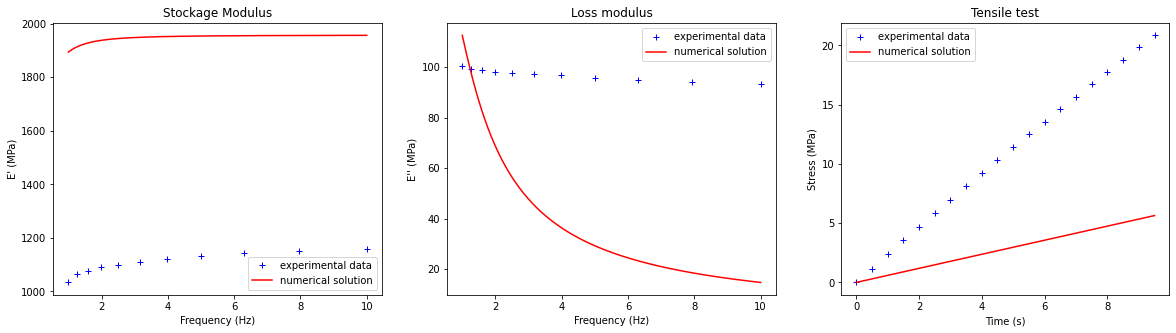

In [298]:
prony_parameters_GA = np.zeros(best.shape)
prony_parameters_GA[ 0 ] = best[ 0 ]*2000+ 1
prony_parameters_GA[ 1:N+1] = best [ 1:N+1]*1000 + 1 
prony_parameters_GA[ N+1: ] = best[ N+1: ] * 1000 + 0.001

freq_2 = np.linspace(1,freq[-1],200)
w_2 = freq_2 * 2 * pi
New_E_stoc,New_E_loss = Moduli(prony_parameters_GA,w_2)

a = plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(freq,stockage,"+b",label='experimental data')
plt.plot(freq_2,New_E_stoc,"r",label='numerical solution')
plt.title("Stockage Modulus")
plt.xlabel("Frequency (Hz)")
plt.ylabel("E' (MPa)")
plt.legend()
plt.subplot(1,3,2)
plt.plot(freq,loss,"+b",label='experimental data')
plt.plot(freq_2,New_E_loss,"r",label='numerical solution')
plt.title("Loss modulus")
plt.xlabel("Frequency (Hz)")
plt.ylabel("E'' (MPa)")
plt.legend()
plt.subplot(1,3,3)
plt.plot(time,sigma_exp,"+b",label='experimental data')
plt.plot(np.linspace(0,time[-1],200) ,predicted_stress(np.linspace(0,time[-1],200) ,prony_parameters_GA,strain_rate),"r",label='numerical solution')
plt.title("Tensile test")
plt.xlabel("Time (s)")
plt.ylabel("Stress (MPa)")
a = plt.legend()

In [258]:
pd.DataFrame(prony_parameters_GA)

,0
0,748.746871
1,40.309118
2,96.102778
3,68.308036
4,102.891402
5,161.704254
6,60.689088
7,185.697791
8,231.758776
9,0.256405
